# [A/B Test] Alipay Marketing Strategy Effectiveness Analysis

Programmer: Zhi Zhou<br>
Date：2025-06-28<p>

A/B testing is commonly used to compare the advantages and disadvantages of different designs or operational plans to aid decision-making. This analysis uses an Alipay marketing campaign as an example, comparing the advertising effectiveness of two marketing strategies using the ad click-through rate (CTR) metric.

## 1. Data Source

The dataset used in this analysis comes from Alibaba Cloud Tianchi: [阿里云天池 - Audience Expansion Dataset](https://tianchi.aliyun.com/dataset/50893)<br>
This dataset contains three tables recording the activity of two Alipay marketing strategies:
- `emb_tb_2.csv`: User feature dataset
- `effect_tb.csv`: Ad click dataset
- `seed_cand_tb.csv`: User type dataset<br>

This analysis report primarily uses the ad click dataset, involving the following fields:
- `dmp_id`: Marketing strategy ID (Not specified in the source data documentation. Based on the data, defined here as: 1: Control group, 2: Marketing Strategy 1, 3: Marketing Strategy 2)
- `user_id`: Alipay user ID
- `label`: Whether the user clicked the activity ad that day (0: Not clicked, 1: Clicked)<br>

## 2. Data Processing

### 2.1 Data Import and Cleaning

In [12]:
# 1. Combine Tables

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# load data
data = pd.read_csv(r'C:\Users\zhizh\Documents\GitHub\data-analyst-projects\alipay-marketing-strategy-effectiveness-analysis\data\effect_tb.csv', header=None)
data.columns = ["dt", "user_id", "label", "dmp_id"]
# The log day attribute is not needed, delete this column
data = data.drop(columns="dt")
data.head(3)

,user_id,label,dmp_id
0,1,0,1
1,1000004,0,1
2,1000004,0,2


In [9]:
# table summary
data.describe()

,user_id,label,dmp_id
count,2.645958e+06,2.645958e+06,2.645958e+06
mean,3.112995e+06,1.456297e-02,1.395761e+00
std,1.828262e+06,1.197952e-01,6.920480e-01
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.526772e+06,0.000000e+00,1.000000e+00
50%,3.062184e+06,0.000000e+00,1.000000e+00
75%,4.721132e+06,0.000000e+00,2.000000e+00
max,6.265402e+06,1.000000e+00,3.000000e+00


In [10]:
# 2. Duplicate Value Handling
# shape of df
data.shape

(2645958, 3)

In [11]:
# distinct count of columns
data.nunique()

user_id    2410683
label            2
dmp_id           3
dtype: int64

The number of data rows does not match the number of unique users. Check for duplicate rows:

In [13]:
data[data.duplicated(keep=False)].sort_values(by=["user_id"])

,user_id,label,dmp_id
8529,1027,0,1
1485546,1027,0,1
1579415,1471,0,1
127827,1471,0,1
1779459,2468,0,1
...,...,...,...
1382121,6264633,0,1
2575140,6264940,0,1
1382245,6264940,0,1
1382306,6265082,0,3


In [15]:
# drop duplicate
data = data.drop_duplicates()

# check if any duplicates left
data[data.duplicated(keep=False)]

,user_id,label,dmp_id


In [19]:
# 3. Null Value Handling
# check null values
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2632975 entries, 0 to 2645957
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   user_id  2632975 non-null  int64
 1   label    2632975 non-null  int64
 2   dmp_id   2632975 non-null  int64
dtypes: int64(3)
memory usage: 80.4 MB


The dataset has no null values and requires no handling.

In [20]:
# 4. Outlier Check
data.pivot_table(index="dmp_id", columns="label", values="user_id",
                 aggfunc="count", margins=True)

label,0,1,All
dmp_id,,,
1,1881745,23918,1905663
2,404811,6296,411107
3,307923,8282,316205
All,2594479,38496,2632975


No abnormal values found in attribute fields; no processing needed.

In [21]:
# 5. Data Types
data.dtypes

user_id    int64
label      int64
dmp_id     int64
dtype: object

Data types are normal; no processing needed.

### 2.2 Sample Size Test

Before conducting the A/B test, we need to check if the sample size meets the minimum required for the experiment.<br>
We use Evan Miller's sample size calculator: [Sample Size Calculator](https://www.evanmiller.org/ab-testing/sample-size.html)<br>
First, we need to set the baseline click rate and the minimum detectable lift. We set the control group's click rate as the baseline.

In [23]:
# click rate of control group
data[data["dmp_id"] == 1]["label"].mean()

np.float64(0.012551012429794775)

The control group click rate is 1.26%. Assuming we want the new marketing strategy to increase the ad click rate by at least 1 percentage point, the calculated minimum required sample size is: 2,167.

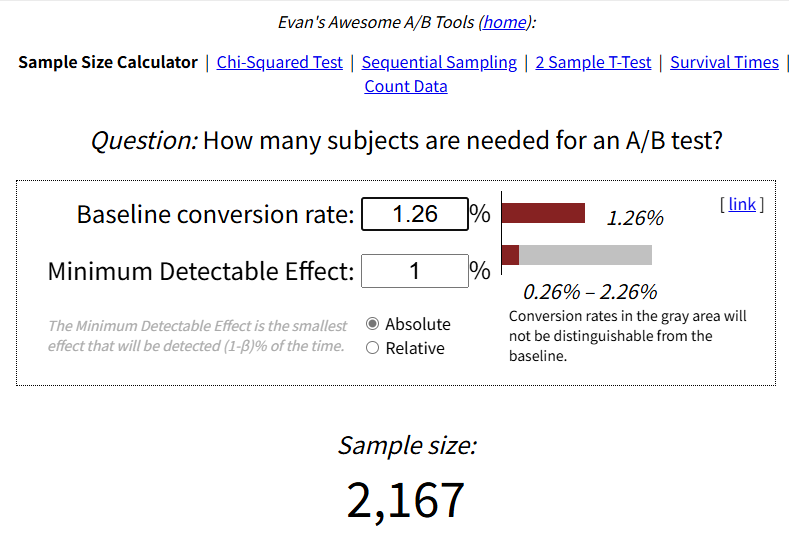

In [43]:
from IPython.display import Image
Image(filename = 'C:/Users/zhizh/Documents/GitHub/data-analyst-projects/alipay-marketing-strategy-effectiveness-analysis/image/SimpleSizeCalculate.png',
      width=640, 
      height=420)

In [44]:
# sample size of campaigns
data["dmp_id"].value_counts()

dmp_id
1    1905663
2     411107
3     316205
Name: count, dtype: int64

The sample sizes for the two marketing campaigns are 411,107 and 316,205, satisfying the minimum sample size requirement.

## 3. Hypothesis Testing

First, observe the click rates of the experimental groups.

In [45]:
# click rate of groups
print("Control Group: ", data[data["dmp_id"] == 1]["label"].mean())
print("Marketing Strategy 1: ", data[data["dmp_id"] == 2]["label"].mean())
print("Marketing Strategy 2: ", data[data["dmp_id"] == 3]["label"].mean())

Control Group:  0.012551012429794775
Marketing Strategy 1:  0.015314747742072015
Marketing Strategy 2:  0.026191869198779274


It can be seen that both Strategy 1 and Strategy 2 show improvements in click rate compared to the control group.
Strategy 1 increased by 0.27 percentage points (1.53% - 1.26%), Strategy 2 increased by 1.36 percentage points (2.62% - 1.26%). Only Strategy 2 meets our earlier requirement for a minimum click rate increase.

Next, we need to conduct a hypothesis test to see if the increase in Strategy 2's click rate is statistically significant.

a. Null Hypothesis and Alternative Hypothesis
Let p1 be the click rate of the control group and p2 be the click rate of Strategy 2.

Null Hypothesis H0: p1 ≥ p2

Alternative Hypothesis H1: p1 < p2

b. Distribution Type, Test Type, and Significance Level
The sample follows a binomial distribution. It's an independent two-sample test with sample size n > 30. The population mean and standard deviation are unknown, so a Z-test is used. The significance level α is set to 0.05.

### 3.1 Method 1: Formula Calculation

In [47]:
# Number of users
n_old = len(data[data.dmp_id == 1])  # Control group
n_new = len(data[data.dmp_id == 3])  # Strategy 2

# Number of clicks
c_old = len(data[data.dmp_id ==1][data.label == 1]) # Warning expected
c_new = len(data[data.dmp_id ==3][data.label == 1]) # Warning expected

# Calculate click rate
r_old = c_old / n_old
r_new = c_new / n_new

# Combined click rate
r = (c_old + c_new) / (n_old + n_new)

print("Combined click rate: ", r)

Combined click rate:  0.014492310074225832


C:\Users\zhizh\AppData\Local\Temp\ipykernel_69388\998000614.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_old = len(data[data.dmp_id ==1][data.label == 1]) # Warning expected
C:\Users\zhizh\AppData\Local\Temp\ipykernel_69388\998000614.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_new = len(data[data.dmp_id ==3][data.label == 1]) # Warning expected


In [48]:
# Calculate test statistic z
z = (r_old - r_new) / np.sqrt(r * (1 - r) * (1/n_old + 1/n_new))

print("Test statistic z: ", z)

Test statistic z:  -59.44168632985996


In [49]:
# Find z quantile for α=0.05
from scipy.stats import norm
z_alpha = norm.ppf(0.05)
z_alpha

np.float64(-1.6448536269514729)

z_alpha = -1.64, Test statistic z = -59.44. This is a left-tailed test, rejection region is (z < z_alpha).

Therefore, we can conclude: The null hypothesis is rejected. The increase in Strategy 2's click rate is statistically significant.

### 3.2 Method 2: Python Function Calculation

Directly calculate the z-score and p-value using Python's statsmodels package.

In [52]:
import statsmodels.stats.proportion as sp
z_score, p = sp.proportions_ztest([c_old, c_new], [n_old, n_new], alternative='smaller')
print("Test statistic z: ", z_score, ", p-value: ", p)

Test statistic z:  -59.44168632985996 , p-value:  0.0


The p-value is approximately 0, p < α. Conclusion same as Method 1: Reject the null hypothesis.

As a supplement, let's test if the increase in Strategy 1's click rate is significant.

In [53]:
# Strategy 1 test
z_score, p = sp.proportions_ztest([c_old, len(data[(data.dmp_id ==2) & (data.label == 1)])], [n_old, len(data[data.dmp_id ==2])], alternative='smaller') # Warning expected
print("Test statistic z: ", z_score, ", p-value: ", p)

Test statistic z:  -14.165873564308429 , p-value:  7.450121742737582e-46


The p-value is approximately 7.45e-46, p < α, meaning the increase is statistically significant. However, because we previously set a requirement for the minimum desired increase in click rate (1 percentage point), and Strategy 1 only increased by 0.27 percentage points, we still only choose Strategy 2 for promotion.

## 4. Conclusion

In summary, among the two marketing strategies, Strategy 2 has a significant effect on improving the ad click-through rate. Compared to the control group, its click rate increased by nearly double. Therefore, Strategy 2 should be chosen for promotion between the two marketing strategies.

## References

- [Analyse ab testing results](https://towardsdatascience.com/ab-testing-with-python-e5964dd66143/)

In [6]:
%notebook "C:/Users/zhizh/Documents/GitHub/data-analyst-projects/alipay-marketing-strategy-effectiveness-analysis/alipay-marketing-strategy-effectiveness-analysis.ipynb"    